In [ ]:
!pip install keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 20.0 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/[2024-2025] AN2DL HOMEWORK 1/Definitive_work

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/117Cy5jmRvw7kUjsl1Y2WzOeI_SAmudjh/[2024-2025] AN2DL HOMEWORK 1/Definitive_work


In [ ]:
# Fix randomness and hide warnings
SEED = 42  # Random seed for reproducibility

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.optimizers import Adam
import keras_cv

# Importing specific TensorFlow Keras layers
from tensorflow.keras.layers import (
    Input, Concatenate, Dense, GlobalAveragePooling2D, Dropout,
    RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
)

# Set seed for TensorFlow
tf.random.set_seed(SEED)
tf.compat.v1.set_random_seed(SEED)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
from datetime import datetime

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


In [ ]:
# Load already preprocessed dataset
data = np.load('preprocessed_dataset.npz')
X_train = data['X_train']
X_test = data['X_test']
X_val = data['X_val']
y_train = data['y_train']
y_test = data['y_test']
y_val = data['y_val']

In [ ]:
def unfreeze(model, fine_tuning_lr, base_idx=1, unfreeze_ratio=0.3):
    """
    Unfreeze a portion of layers in the base model (second layer of the full model)
    while excluding BatchNormalization layers. Prints the number of unfrozen layers
    and total layers in the base model.

    Args:
        model: The entire transfer learning model (with classification head).
        unfreeze_ratio: Proportion of layers to unfreeze in the base model (default is 30%).

    Returns:
        Modified model with the base model layers updated.
    """
    # Extract the base model (assumed to be the second layer in the full model)
    base_model = model.layers[base_idx]

    # Unfreeze the base model
    base_model.trainable = True

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Determine layers to unfreeze
    total_layers = len(base_model.layers)
    unfreeze_start = int(total_layers * (1 - unfreeze_ratio))
    unfrozen_layers_count = 0

    for i, layer in enumerate(base_model.layers):
        if i >= unfreeze_start:
            # Exclude BatchNormalization layers from being trainable
            if not isinstance(layer, tf.keras.layers.BatchNormalization):
                layer.trainable = True
                unfrozen_layers_count += 1

    # Print the count of unfrozen layers
    print(f"{unfrozen_layers_count}/{total_layers} layers unfrozen.")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(fine_tuning_lr),
        loss='categorical_crossentropy',
        metrics=[tfk.metrics.F1Score(average='macro')]
    )

    return model

def plot_history(history_tl, history_ft, model_name):
    # Create figures and axes
    fig, axs = plt.subplots(2, figsize=(8, 10))

    # Extract relevant metrics
    tl_loss = history_tl['loss']
    tl_val_loss = history_tl['val_loss']
    tl_f1 = history_tl['f1_score']
    tl_val_f1 = history_tl['val_f1_score']

    ft_loss = history_ft['loss']
    ft_val_loss = history_ft['val_loss']
    ft_f1 = history_ft['f1_score']
    ft_val_f1 = history_ft['val_f1_score']

    # Concatenate transfer learning and fine-tuning histories
    loss = tl_loss + ft_loss
    val_loss = tl_val_loss + ft_val_loss
    f1 = tl_f1 + ft_f1
    val_f1 = tl_val_f1 + ft_val_f1

    # Calculate the epoch where fine-tuning starts
    ft_start = len(tl_loss)

    # Plot Categorical Crossentropy
    axs[0].plot(loss, linestyle=':', label='Training')
    axs[0].plot(val_loss, label='Validation')
    axs[0].axvline(x=ft_start-0.5, color='r', linestyle='--', label='Start of Fine-tuning')
    axs[0].set_title(f'Categorical Crossentropy - {model_name}')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc='best')

    # Plot F1 Score
    axs[1].plot(f1, linestyle=':', label='Training')
    axs[1].plot(val_f1, label='Validation')
    axs[1].axvline(x=ft_start-0.5, color='r', linestyle='--', label='Start of Fine-tuning')
    axs[1].set_title(f'F1 Score - {model_name}')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('F1 Score')
    axs[1].legend(loc='best')

    # Add text annotations
    axs[0].text(ft_start/2, axs[0].get_ylim()[1], 'Transfer Learning',
                horizontalalignment='center', verticalalignment='bottom')
    axs[0].text((len(loss) + ft_start)/2, axs[0].get_ylim()[1], 'Fine-tuning',
                horizontalalignment='center', verticalalignment='bottom')

    axs[1].text(ft_start/2, axs[1].get_ylim()[1], 'Transfer Learning',
                horizontalalignment='center', verticalalignment='bottom')
    axs[1].text((len(f1) + ft_start)/2, axs[1].get_ylim()[1], 'Fine-tuning',
                horizontalalignment='center', verticalalignment='bottom')

    # Layout so plots do not overlap
    fig.tight_layout()

    # Show plot
    plt.show()

def predict_and_score(model):
    # Make predictions for the model on the test set
    y_pred = np.argmax(model.predict(X_test), axis=-1)

    # Calculate and display test set accuracy
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
    test_precision = precision_score(y_test, y_pred, average='weighted')
    print(f'Precision score over the test set: {round(test_precision, 4)}')
    test_recall = recall_score(y_test, y_pred, average='weighted')
    print(f'Recall score over the test set: {round(test_recall, 4)}')
    test_f1 = f1_score(y_test, y_pred, average='weighted')
    print(f'F1 score over the test set: {round(test_f1, 4)}')

    # Compute confusion matrices for both models
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    plt.tight_layout()
    plt.show()

In [ ]:
# Convert one-hot encoded labels to integer labels
if y_train.ndim > 1:
    y_int_train = np.argmax(y_train, axis=1)  # Flatten the one-hot labels to class indices
else:
    y_int_train = y_train  # Already in integer format

# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_int_train), y=y_int_train)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Parameters
INPUT_SHAPE = X_train.shape[1:]
OUTPUT_SHAPE = y_train.shape[1]
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
FINE_TUNING_LEARNING_RATE = 1e-4
EPOCHS = 20
FINE_TUNE_EPOCHS = 10
UNFREEZE_RATIO = 0.3

# Data Augmentation

## Traditional

In [ ]:
# Traditional augmentation pipeline
def create_train_generator(X_train, y_train, target_size=(96, 96), batch_size=32):
    # Ensure X_train and y_train are numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Define the data generator with augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,             # Random rotation
        zoom_range=0.2,                # Random zoom
        horizontal_flip=True,          # Flip horizontally
        vertical_flip=True,            # Vertical flip
        fill_mode="nearest"            # Fill missing pixels
    )

    # Create a generator for training data using flow method
    train_generator = train_datagen.flow(
        X_train,                      # Input images (X_train)
        y_train,                      # Labels (y_train)
        batch_size=batch_size,        # Number of images per batch
        shuffle=True                  # Shuffle the data
    )

    return train_generator

def create_augmented_dataset_from_generator(train_generator, augment_count=2):
    """
    Generates an augmented dataset from a Keras ImageDataGenerator.

    Parameters:
        train_generator: The ImageDataGenerator.flow_from_directory object.
        augment_count: Number of augmentation cycles (iterations through the generator).

    Returns:
        augmented_dataset: A single dataset as a tuple (images, labels).
    """
    augmented_images = []
    augmented_labels = []

    # Iterate through the generator to collect augmented data
    for _ in range(augment_count):
        for images, labels in train_generator:
            augmented_images.append(images)
            augmented_labels.append(labels)

            # Stop once we've processed the desired augment_count
            if len(augmented_images) >= len(train_generator) * augment_count:
                break

    # Concatenate batches into a single dataset
    augmented_images = np.concatenate(augmented_images, axis=0)
    augmented_labels = np.concatenate(augmented_labels, axis=0)

    # Bundle into a single dataset as a tuple
    augmented_dataset = (augmented_images, augmented_labels)

    return augmented_dataset

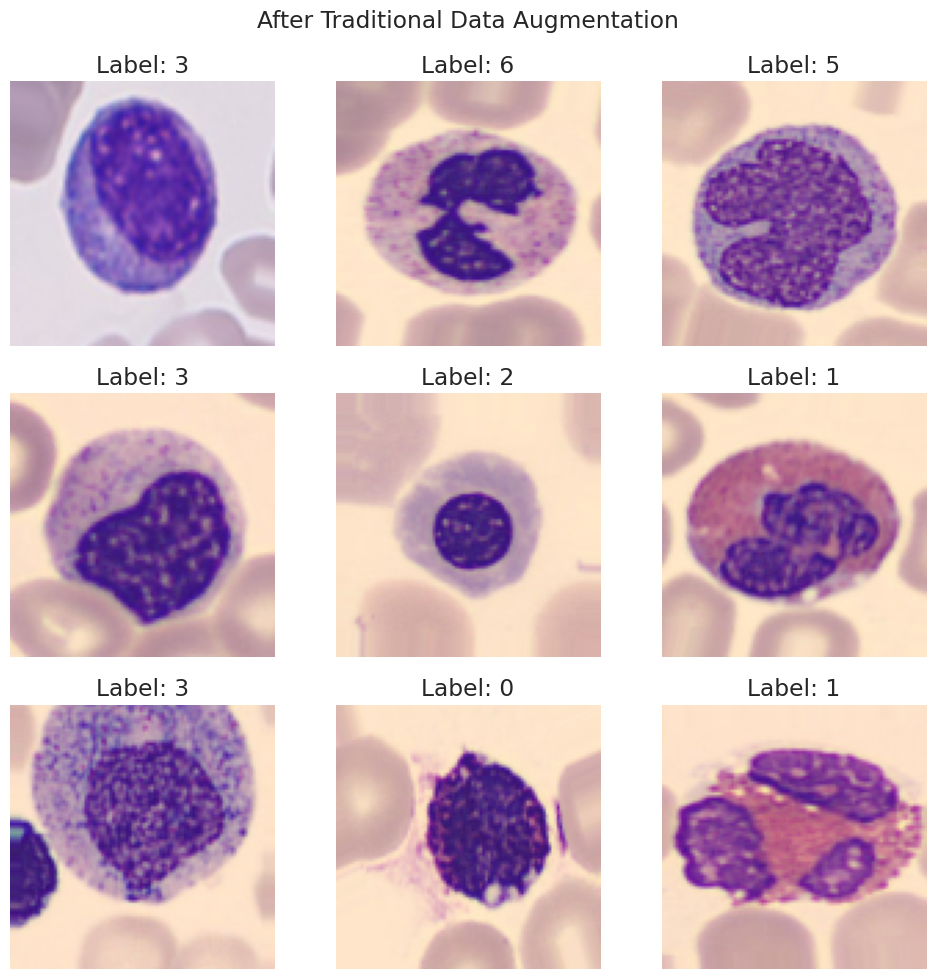

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_dataset(dataset, title):
    # dataset is assumed to be a tuple (images, labels)
    images, labels = dataset  # Directly unpack the tuple

    # If labels are not one-hot encoded, no need to convert
    # Check if labels have more than one dimension (indicating one-hot encoding)
    if labels.ndim > 1:
        labels = tf.argmax(labels, axis=1)

    images = images / 255.0  # Scale to [0, 255]

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title)

    # Plot images
    for i in range(min(9, len(images))):
        axs[i // 3, i % 3].imshow(images[i])
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(f'Label: {labels[i]}')

    plt.tight_layout()
    plt.show()
    plt.savefig("Augmented_Images_T.png")

# Visualize the augmented dataset
train_generator = create_train_generator(X_train, y_train)
augmented_train_dataset = create_augmented_dataset_from_generator(train_generator, 1)
visualize_dataset(augmented_train_dataset, title="After Traditional Data Augmentation")

In [ ]:
for X_batch, y_batch in train_generator:
        print("Shape of y_batch:", y_batch.shape)  # Check the shape
        break  # Stop after one batch

Shape of y_batch: (32, 8)


In [ ]:
from tensorflow.keras.applications import EfficientNetV2M

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Pass through the base model
x = base_model(inputs)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_activation      │ (None, 48, 48, 24)          │              

 Total params: 53,160,636 (202.79 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2m_traditional_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2m_traditional_da['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2m_traditional_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2m_traditional_da['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2M_augmented.keras'
model.save(model_filename)

# Delete the model to free up resources
# del model

Epoch 1/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 200s 368ms/step - f1_score: 0.4845 - loss: 1.5176 - val_f1_score: 0.8131 - val_loss: 0.6586
Epoch 2/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 33s 100ms/step - f1_score: 0.7456 - loss: 0.8266 - val_f1_score: 0.8556 - val_loss: 0.4847
Epoch 3/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - f1_score: 0.7795 - loss: 0.6742 - val_f1_score: 0.8564 - val_loss: 0.4518
Epoch 4/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - f1_score: 0.7864 - loss: 0.6272 - val_f1_score: 0.8746 - val_loss: 0.3911
Epoch 5/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 36s 112ms/step - f1_score: 0.8031 - loss: 0.5869 - val_f1_score: 0.8712 - val_loss: 0.3662
Epoch 6/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - f1_score: 0.8164 - loss: 0.5541 - val_f1_score: 0.8944 - val_loss: 0.3320
Epoch 7/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 32s 99ms/step - f1_score: 0.8264 - loss: 0.5211 - val_f1_score: 0.8837 - val_loss: 0.3303
Epoch 8/20
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 99ms/step - f1_score: 0.8276 - loss: 0.503

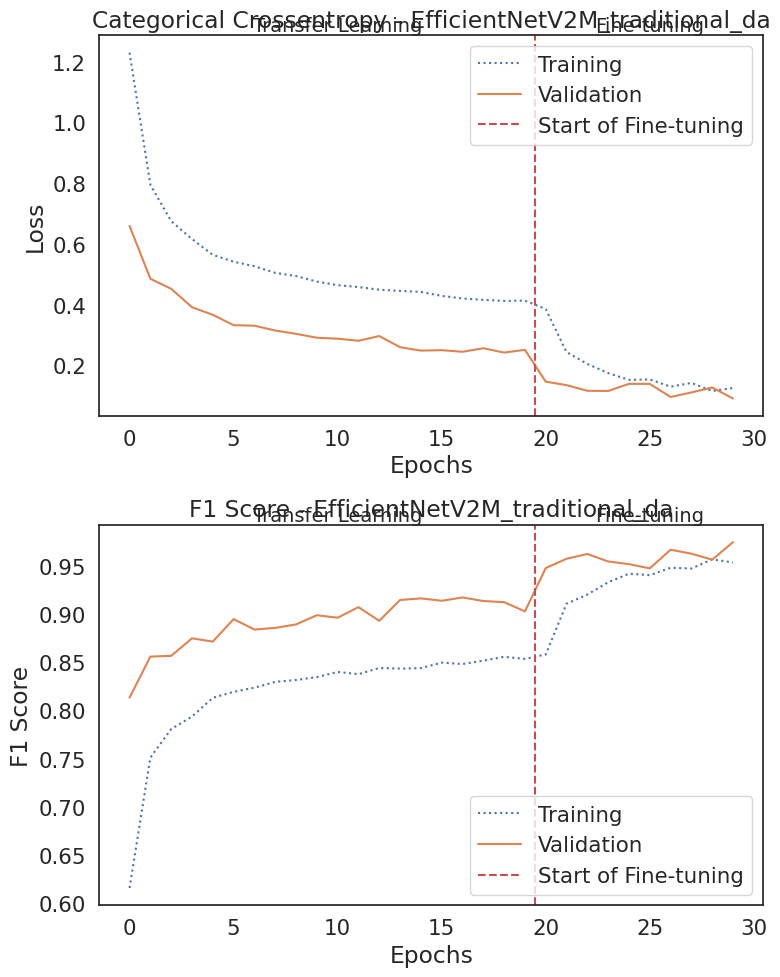

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2m_traditional_da, history_ft_efficientnetv2m_traditional_da, "EfficientNetV2M_traditional_da")

18/18 ━━━━━━━━━━━━━━━━━━━━ 28s 790ms/step
Accuracy score over the test set: 0.9696
Precision score over the test set: 0.9724
Recall score over the test set: 0.9696
F1 score over the test set: 0.9701


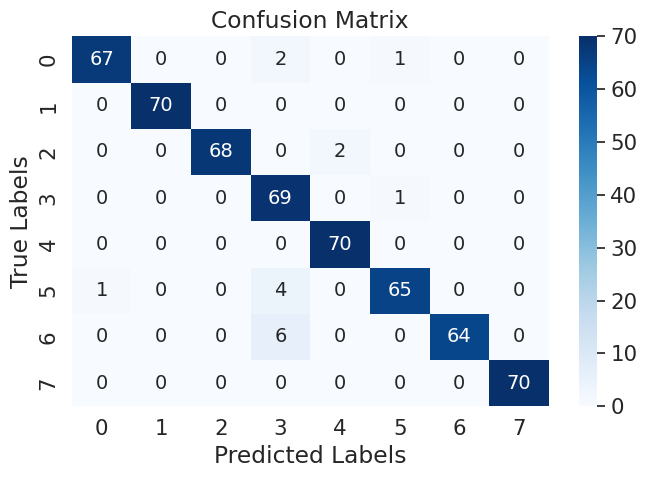

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('EfficientNetV2M_augmented.keras')
#Make predictions for model1 on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Optionally, you can delete the models to free up resources
#del model

## MixUp + CutMix

In [ ]:
def mixup(batch_images, batch_labels, alpha=0.5):
    """ Apply Mixup augmentation to the batch of images and labels. """
    batch_size = batch_images.shape[0]
    lam = np.random.beta(alpha, alpha, size=(batch_size,))  # Beta distribution for alpha
    mixed_images = np.zeros_like(batch_images)
    mixed_labels = np.zeros_like(batch_labels)

    for i in range(batch_size):
        # Random index for pairing
        index = np.random.randint(0, batch_size)
        # Mix images and labels
        mixed_images[i] = lam[i] * batch_images[i] + (1 - lam[i]) * batch_images[index]
        mixed_labels[i] = lam[i] * batch_labels[i] + (1 - lam[i]) * batch_labels[index]

    return mixed_images, mixed_labels

def cutmix(batch_images, batch_labels, alpha=0.5):
    """ Apply CutMix augmentation to the batch of images and labels. """
    batch_size = batch_images.shape[0]
    mixed_images = np.copy(batch_images)
    mixed_labels = np.copy(batch_labels)

    for i in range(batch_size):
        # Random index for pairing
        index = np.random.randint(0, batch_size)
        # Random bounding box coordinates
        h, w, _ = batch_images.shape[1:]
        x1 = random.randint(0, w)
        y1 = random.randint(0, h)
        x2 = random.randint(x1, w)
        y2 = random.randint(y1, h)

        # Cut and paste
        mixed_images[i, y1:y2, x1:x2, :] = batch_images[index, y1:y2, x1:x2, :]
        # Adjust the labels (linear combination)
        lambda_cutmix = (x2 - x1) * (y2 - y1) / (w * h)
        mixed_labels[i] = lambda_cutmix * batch_labels[i] + (1 - lambda_cutmix) * batch_labels[index]

    return mixed_images, mixed_labels

def create_train_generator(X_train, y_train, target_size=(96, 96), batch_size=32, augmentation_type='both'):
    """
    Generate training data with both Mixup and CutMix applied alternatively.

    Parameters:
        augmentation_type (str): 'both' to apply both techniques.
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Define the data generator for traditional augmentation
    train_datagen = ImageDataGenerator()

    # Create a generator for training data using flow method
    train_generator = train_datagen.flow(
        X_train,                      # Input images (X_train)
        y_train,                      # Labels (y_train)
        batch_size=batch_size,        # Number of images per batch
        shuffle=True                  # Shuffle the data
    )

def augmented_generator():
    """ Generator function to apply Mixup or CutMix on each batch. """
    while True:
        # Get the next batch of images and labels
        batch_images, batch_labels = next(train_generator)

        if augmentation_type == 'mixup':
            # Apply Mixup
            batch_images, batch_labels = mixup(batch_images, batch_labels)
        elif augmentation_type == 'cutmix':
            # Apply CutMix
            batch_images, batch_labels = cutmix(batch_images, batch_labels)
        elif augmentation_type == 'both':
            # Randomly apply either Mixup or CutMix on the batch
            if random.random() < 0.5:
                batch_images, batch_labels = mixup(batch_images, batch_labels)
            else:
                batch_images, batch_labels = cutmix(batch_images, batch_labels)

        # Yield the augmented batch
        yield batch_images, batch_labels

return augmented_generator()

def create_augmented_dataset_from_generator(train_generator, augment_count=2):
    """
    Generates an augmented dataset from a Keras ImageDataGenerator.

    Parameters:
        train_generator: The custom generator with Mixup or CutMix.
        augment_count: Number of augmentation cycles (iterations through the generator).

    Returns:
        augmented_dataset: A single dataset as a tuple (images, labels).
    """
    augmented_images = []
    augmented_labels = []

    # Iterate through the generator to collect augmented data
    for _ in range(augment_count):
        for images, labels in train_generator:
            augmented_images.append(images)
            augmented_labels.append(labels)

            # Stop once we've processed the desired augment_count
            if len(augmented_images) >= augment_count:
                break

    # Concatenate batches into a single dataset
    augmented_images = np.concatenate(augmented_images, axis=0)
    augmented_labels = np.concatenate(augmented_labels, axis=0)

    # Bundle into a single dataset as a tuple
    augmented_dataset = (augmented_images, augmented_labels)

    return augmented_dataset

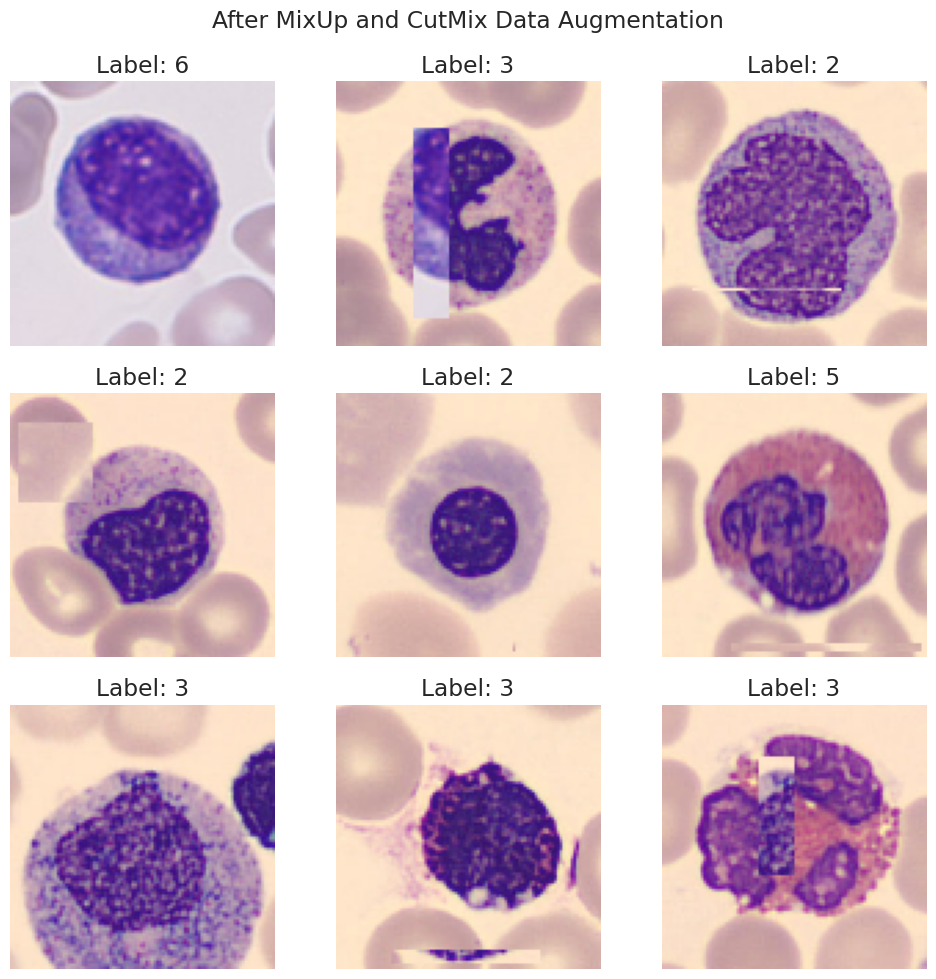

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_dataset(dataset, title):
    # dataset is assumed to be a tuple (images, labels)
    images, labels = dataset  # Directly unpack the tuple

    # If labels are not one-hot encoded, no need to convert
    if labels.ndim > 1:
        labels = tf.argmax(labels, axis=1)

    # Ensure images are scaled to the range [0, 1]
    images = np.clip(images, 0, 255)  # Ensure values are within [0, 255]
    images = images.astype(np.uint8)  # Convert to uint8 if required

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title)

    # Plot images
    for i in range(min(9, len(images))):
        axs[i // 3, i % 3].imshow(images[i])
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(f'Label: {labels[i]}')

    plt.tight_layout()
    plt.show()
    plt.savefig("Augmented_Images_MC.png")

# Example usage
train_generator = create_train_generator(X_train, y_train, target_size=(96, 96), batch_size=32)
augmented_train_dataset = create_augmented_dataset_from_generator(train_generator, 1)
visualize_dataset(augmented_train_dataset, title="After MixUp and CutMix Data Augmentation")

In [ ]:
tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Pass through the base model
x = base_model(inputs)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_activation      │ (None, 48, 48, 24)          │              

 Total params: 53,160,636 (202.79 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2m_mc_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE
    #class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2m_mc_da['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2m_mc_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE
    #class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2m_mc_da['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2M_MC_AUGMENTATION.keras'
model.save(model_filename)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 644ms/step - f1_score: 0.1678 - loss: 1.9597 - val_f1_score: 0.3385 - val_loss: 1.5094
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - f1_score: 0.2325 - loss: 1.8495 - val_f1_score: 0.5178 - val_loss: 1.2767
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - f1_score: 0.2926 - loss: 1.7819 - val_f1_score: 0.6258 - val_loss: 1.1850
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 39s 495ms/step - f1_score: 0.3067 - loss: 1.7285 - val_f1_score: 0.7851 - val_loss: 1.1062
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - f1_score: 0.3453 - loss: 1.7400 - val_f1_score: 0.7003 - val_loss: 1.0485
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1_score: 0.3889 - loss: 1.6412 - val_f1_score: 0.7448 - val_loss: 1.0244
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 65ms/step - f1_score: 0.3646 - loss: 1.7218 - val_f1_score: 0.7613 - val_loss: 0.9929
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - f1_score: 0.3525 - loss: 1.7108 - val_f1_score: 0.757

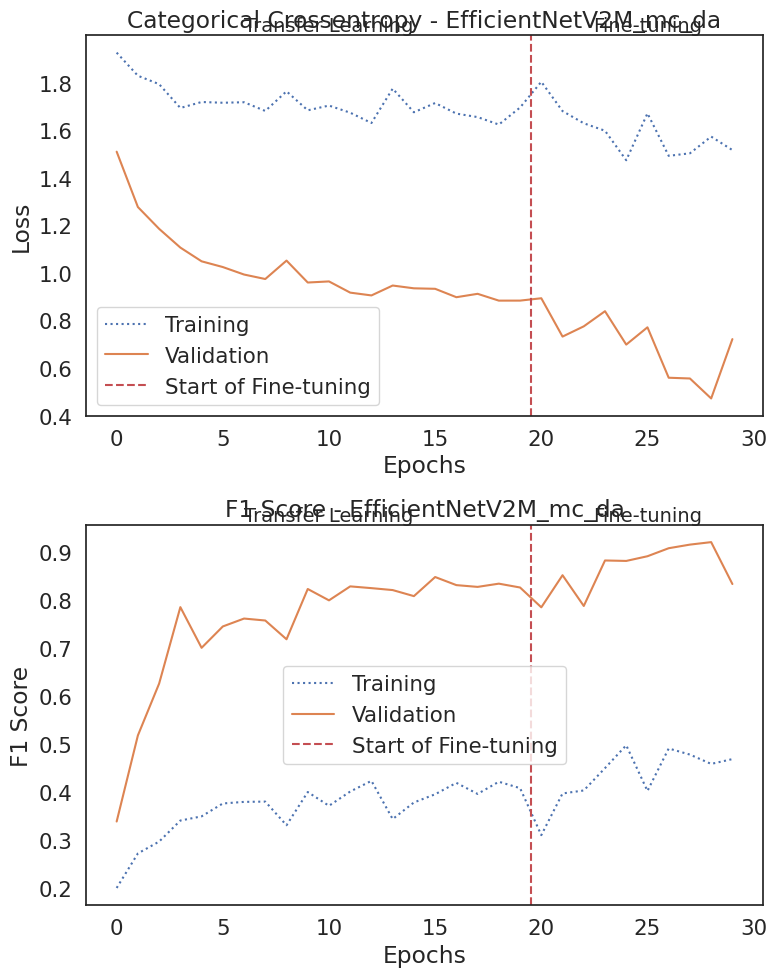

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2m_mc_da, history_ft_efficientnetv2m_mc_da, "EfficientNetV2M_mc_da")

18/18 ━━━━━━━━━━━━━━━━━━━━ 26s 786ms/step
Accuracy score over the test set: 0.8196
Precision score over the test set: 0.8581
Recall score over the test set: 0.8196
F1 score over the test set: 0.8127


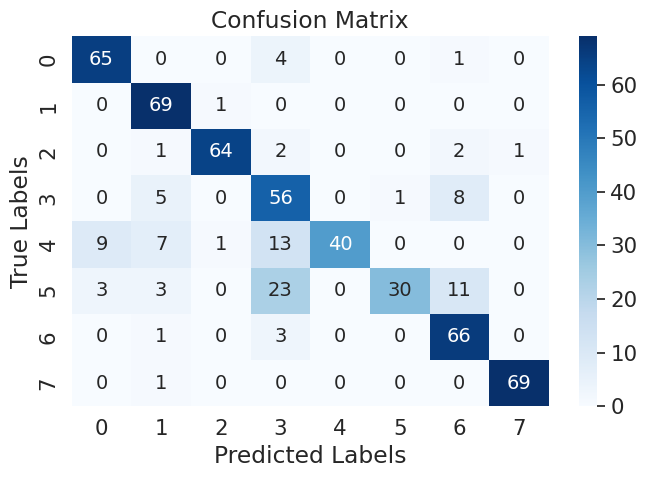

In [ ]:
# Import model
model = tf.keras.models.load_model('EfficientNetV2M_MC_AUGMENTATION.keras')

# Make predictions for model1 on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
#y_test = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Delete the model to free up resources
# del model

## MixUp + CutMix + Traditional

In [ ]:
def mixup(batch_images, batch_labels, alpha=0.5):
    """ Apply Mixup augmentation to the batch of images and labels. """
    batch_size = batch_images.shape[0]
    lam = np.random.beta(alpha, alpha, size=(batch_size,))  # Beta distribution for alpha
    mixed_images = np.zeros_like(batch_images)
    mixed_labels = np.zeros_like(batch_labels)

    for i in range(batch_size):
        # Random index for pairing
        index = np.random.randint(0, batch_size)
        # Mix images and labels
        mixed_images[i] = lam[i] * batch_images[i] + (1 - lam[i]) * batch_images[index]
        mixed_labels[i] = lam[i] * batch_labels[i] + (1 - lam[i]) * batch_labels[index]

    return mixed_images, mixed_labels

def cutmix(batch_images, batch_labels, alpha=0.5):
    """ Apply CutMix augmentation to the batch of images and labels. """
    batch_size = batch_images.shape[0]
    mixed_images = np.copy(batch_images)
    mixed_labels = np.copy(batch_labels)

    for i in range(batch_size):
        # Random index for pairing
        index = np.random.randint(0, batch_size)
        # Random bounding box coordinates
        h, w, _ = batch_images.shape[1:]
        x1 = random.randint(0, w)
        y1 = random.randint(0, h)
        x2 = random.randint(x1, w)
        y2 = random.randint(y1, h)

        # Cut and paste
        mixed_images[i, y1:y2, x1:x2, :] = batch_images[index, y1:y2, x1:x2, :]
        # Adjust the labels (linear combination)
        lambda_cutmix = (x2 - x1) * (y2 - y1) / (w * h)
        mixed_labels[i] = lambda_cutmix * batch_labels[i] + (1 - lambda_cutmix) * batch_labels[index]

    return mixed_images, mixed_labels

def create_train_generator(X_train, y_train, target_size=(96, 96), batch_size=32, augmentation_type='both'):
    """
    Generate training data with both Mixup and CutMix applied alternatively.

    Parameters:
        augmentation_type (str): 'both' to apply both techniques.
    """
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Define the data generator for traditional augmentation
    train_datagen = ImageDataGenerator(
        rotation_range=20,             # Random rotation
        zoom_range=0.2,                # Random zoom
        horizontal_flip=True,          # Flip horizontally
        vertical_flip=True,            # Vertical flip
        fill_mode="nearest"            # Fill missing pixels
    )

    # Create a generator for training data using flow method
    train_generator = train_datagen.flow(
        X_train,                      # Input images (X_train)
        y_train,                      # Labels (y_train)
        batch_size=batch_size,        # Number of images per batch
        shuffle=True                  # Shuffle the data
    )

    def augmented_generator():
        """ Generator function to apply Mixup or CutMix on each batch. """
        while True:
            # Get the next batch of images and labels
            batch_images, batch_labels = next(train_generator)

            if augmentation_type == 'mixup':
                # Apply Mixup
                batch_images, batch_labels = mixup(batch_images, batch_labels)
            elif augmentation_type == 'cutmix':
                # Apply CutMix
                batch_images, batch_labels = cutmix(batch_images, batch_labels)
            elif augmentation_type == 'both':
                # Randomly apply either Mixup or CutMix on the batch
                if random.random() < 0.5:
                    batch_images, batch_labels = mixup(batch_images, batch_labels)
                else:
                    batch_images, batch_labels = cutmix(batch_images, batch_labels)

            # Yield the augmented batch
            yield batch_images, batch_labels

    return augmented_generator()

def create_augmented_dataset_from_generator(train_generator, augment_count=2):
    """
    Generates an augmented dataset from a Keras ImageDataGenerator.

    Parameters:
        train_generator: The custom generator with Mixup or CutMix.
        augment_count: Number of augmentation cycles (iterations through the generator).

    Returns:
        augmented_dataset: A single dataset as a tuple (images, labels).
    """
    augmented_images = []
    augmented_labels = []

    # Iterate through the generator to collect augmented data
    for _ in range(augment_count):
        for images, labels in train_generator:
            augmented_images.append(images)
            augmented_labels.append(labels)

            # Stop once we've processed the desired augment_count
            if len(augmented_images) >= augment_count:
                break

    # Concatenate batches into a single dataset
    augmented_images = np.concatenate(augmented_images, axis=0)
    augmented_labels = np.concatenate(augmented_labels, axis=0)

    # Bundle into a single dataset as a tuple
    augmented_dataset = (augmented_images, augmented_labels)

    return augmented_dataset

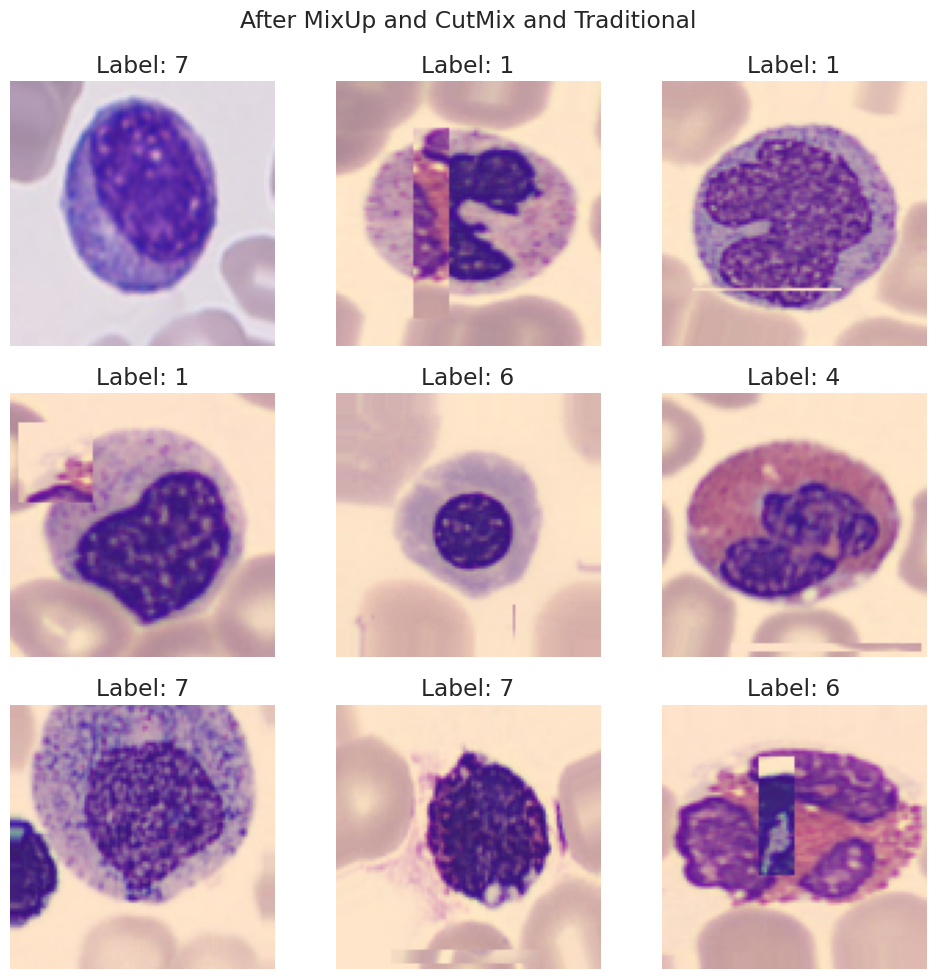

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_dataset(dataset, title):
    # dataset is assumed to be a tuple (images, labels)
    images, labels = dataset  # Directly unpack the tuple

    # If labels are not one-hot encoded, no need to convert
    if labels.ndim > 1:
        labels = tf.argmax(labels, axis=1)

    # Ensure images are scaled to the range [0, 1]
    images = np.clip(images, 0, 255)  # Ensure values are within [0, 255]
    images = images.astype(np.uint8)  # Convert to uint8 if required

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title)

    # Plot images
    for i in range(min(9, len(images))):
        axs[i // 3, i % 3].imshow(images[i])
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(f'Label: {labels[i]}')

    plt.tight_layout()
    plt.show()
    plt.savefig("Augmented_Images_MCT.png")

# Example usage
train_generator = create_train_generator(X_train, y_train, target_size=(96, 96), batch_size=32)
augmented_train_dataset = create_augmented_dataset_from_generator(train_generator, 1)
visualize_dataset(augmented_train_dataset, title="After MixUp and CutMix and Traditional")

In [ ]:
from tensorflow.keras.applications import EfficientNetV2M

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Pass through the base model
x = base_model(inputs)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

#add ag

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_activation      │ (None, 48, 48, 24)          │              

 Total params: 53,160,636 (202.79 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2m_mct_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE
    #class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2m_mct_da['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2m_mct_da = model.fit(
    train_generator,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // BATCH_SIZE
    #class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2m_mct_da['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2M_MCT_AUGMENTATION.keras'
model.save(model_filename)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 42s 527ms/step - f1_score: 0.3971 - loss: 1.7113 - val_f1_score: 0.8827 - val_loss: 0.8200
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 112ms/step - f1_score: 0.4160 - loss: 1.6113 - val_f1_score: 0.8328 - val_loss: 0.8367
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - f1_score: 0.3952 - loss: 1.6714 - val_f1_score: 0.8358 - val_loss: 0.7928
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - f1_score: 0.4078 - loss: 1.7167 - val_f1_score: 0.8709 - val_loss: 0.7881
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - f1_score: 0.4032 - loss: 1.6527 - val_f1_score: 0.8663 - val_loss: 0.7719
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - f1_score: 0.4004 - loss: 1.6941 - val_f1_score: 0.8795 - val_loss: 0.7966
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - f1_score: 0.4076 - loss: 1.6384 - val_f1_score: 0.8265 - val_loss: 0.8178
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - f1_score: 0.4347 - loss: 1.5912 - val_f1_score: 0.8

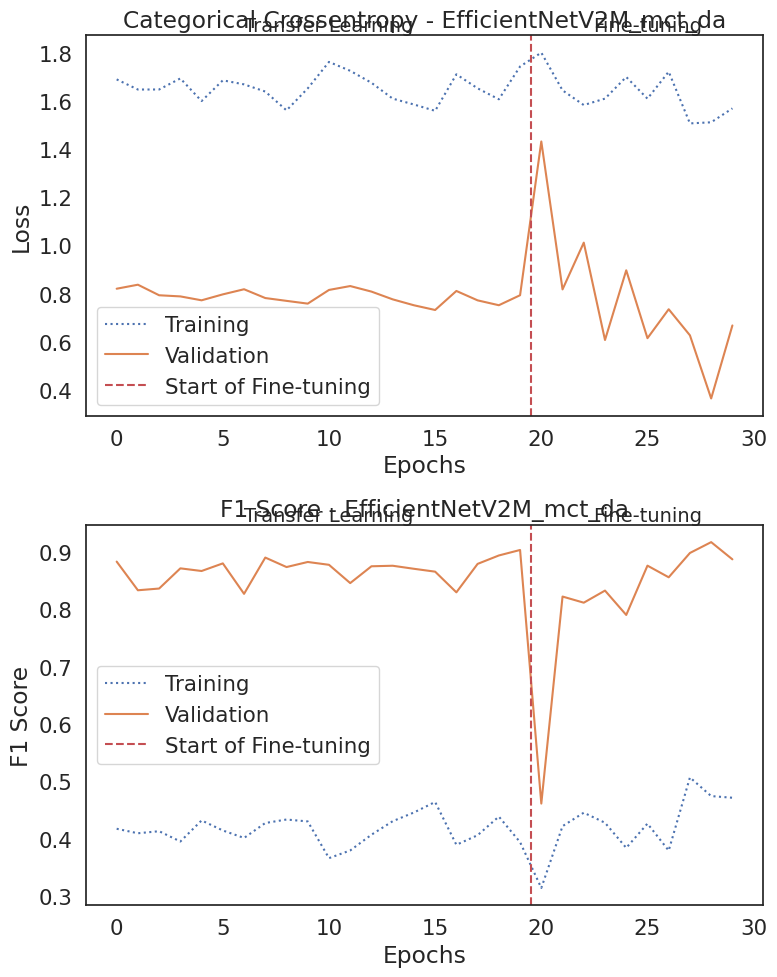

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2m_mct_da, history_ft_efficientnetv2m_mct_da, "EfficientNetV2M_mct_da")

18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
Accuracy score over the test set: 0.875
Precision score over the test set: 0.8882
Recall score over the test set: 0.875
F1 score over the test set: 0.8767


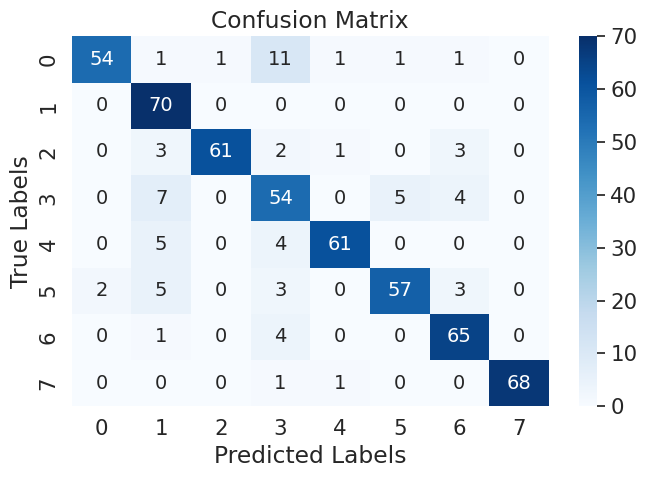

In [ ]:
# Make predictions for model1 on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)
#y_test = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Delete the model to free up resources
del model

## RandAugment

In [ ]:
# Define the RandAugment layer
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),  # Assuming images are in the range [0, 255]
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=1.0,
)

# Function to apply RandAugment
def apply_rand_augment(images, labels):
    augmented_images = rand_augment(images)
    return augmented_images, labels

# Convert NumPy dataset to TensorFlow Dataset
AUTOTUNE = tf.data.AUTOTUNE

# Assuming X_train is of shape (num_samples, height, width, channels) and y_train is labels
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Create a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_tf, y_train_tf))

# Apply RandAugment and optimize dataset
train_dataset = (
    train_dataset
    .map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
    .batch(32)  # Adjust batch size as needed
    .prefetch(AUTOTUNE)
)

In [ ]:
# Convert tf.data.Dataset to NumPy arrays
def dataset_to_numpy(dataset):
    X_list = []
    y_list = []

    for images, labels in dataset:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())

    # Combine all batches into single NumPy arrays
    X_train = np.concatenate(X_list, axis=0)
    y_train = np.concatenate(y_list, axis=0)

    return X_train, y_train

# Assuming train_dataset is batched
X_train, y_train = dataset_to_numpy(train_dataset)

# X_train and y_train are now NumPy arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (10251, 96, 96, 3)
y_train shape: (10251, 8)


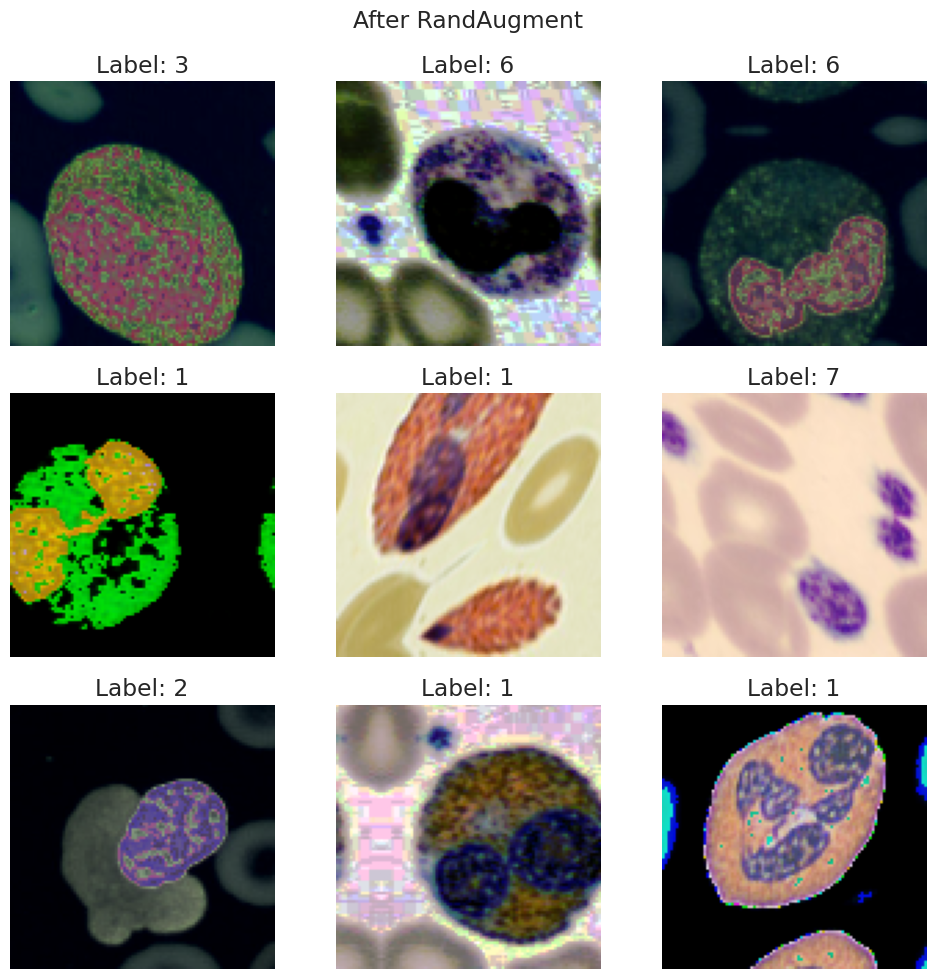

<Figure size 640x480 with 0 Axes>

In [ ]:
def visualize_dataset(dataset, title):
    # dataset is assumed to be a tuple (images, labels)
    images, labels = dataset  # Directly unpack the tuple

    # If labels are not one-hot encoded, no need to convert
    # Check if labels have more than one dimension (indicating one-hot encoding)
    if labels.ndim > 1:
        labels = tf.argmax(labels, axis=1)

    images = images / 255.0  # Scale to [0, 255]

    # Create a figure with subplots
    fig, axs = plt.subplots(3, 3, figsize=(10, 10))
    fig.suptitle(title)

    # Plot images
    for i in range(min(9, len(images))):
        axs[i // 3, i % 3].imshow(images[i])
        axs[i // 3, i % 3].axis('off')
        axs[i // 3, i % 3].set_title(f'Label: {labels[i]}')

    plt.tight_layout()
    plt.show()
    plt.savefig("After RandAugment.png")

# Visualize the augmented dataset
visualize_dataset((X_train, y_train), title="After RandAugment")

In [ ]:
!pip install keras-cv

tf.keras.backend.clear_session()

# Define base model
base_model = EfficientNetV2M(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE,
    pooling="avg",
    include_preprocessing=True
)

# Freeze the base model initially
base_model.trainable = False

# Define inputs
inputs = tfkl.Input(shape=INPUT_SHAPE)

# Pass through the base model
x = base_model(inputs)

# Add classifier head
outputs = tfkl.Dense(OUTPUT_SHAPE, activation='softmax')(x)

# Create the complete model
model = tfk.models.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=[tfk.metrics.F1Score(average='macro')]
)

# Print the model summary
model.summary(expand_nested=True)

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-m (Functional)        │ (None, 1280)                │      53,150,388 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling (Rescaling)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, 48, 48, 24)          │             648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, 48, 48, 24)          │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_project_activation      │ (None, 48, 48, 24)          │               0 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_drop (Dropout)          │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1b_add (Add)               │ (None, 48, 48, 24)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_conv (Conv2D)   │ (None, 48, 48, 24)          │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_bn              │ (None, 48, 48, 24)          │              96 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1c_project_activation      │ (None, 48, 48, 24)          │              

 Total params: 53,160,636 (202.79 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Transfer learning
history_tl_efficientnetv2m_random_da = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Transfer learning validation F1Score: {round(max(history_tl_efficientnetv2m_random_da['val_f1_score'])* 100, 2)}%")

# Unfreeze base model layers for fine-tuning (30% default)
model = unfreeze(model, fine_tuning_lr=FINE_TUNING_LEARNING_RATE)

# Fine-tuning
history_ft_efficientnetv2m_random_da = model.fit(
    x=X_train,
    y=y_train,
    batch_size=BATCH_SIZE,
    epochs=FINE_TUNE_EPOCHS,
    validation_data=(X_val, y_val),
    class_weight=class_weights
).history

# Print score
print(f"Fine-tuning validation F1Score: {round(max(history_ft_efficientnetv2m_random_da['val_f1_score'])* 100, 2)}%")

# Save the trained model to a file
model_filename = 'EfficientNetV2M_random_augmentation.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - f1_score: 0.3089 - loss: 1.8749 - val_f1_score: 0.7379 - val_loss: 1.1394
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - f1_score: 0.5682 - loss: 1.3571 - val_f1_score: 0.7891 - val_loss: 0.8720
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - f1_score: 0.6156 - loss: 1.1750 - val_f1_score: 0.7979 - val_loss: 0.7497
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - f1_score: 0.6379 - loss: 1.0878 - val_f1_score: 0.8174 - val_loss: 0.6665
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 141ms/step - f1_score: 0.6559 - loss: 1.0261 - val_f1_score: 0.8342 - val_loss: 0.6137
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - f1_score: 0.6729 - loss: 0.9803 - val_f1_score: 0.8448 - val_loss: 0.5684
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 144ms/step - f1_score: 0.6785 - loss: 0.9416 - val_f1_score: 0.8477 - val_loss: 0.5423
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - f1_score: 0.6854 - loss: 0.9159 - val_f1_sco

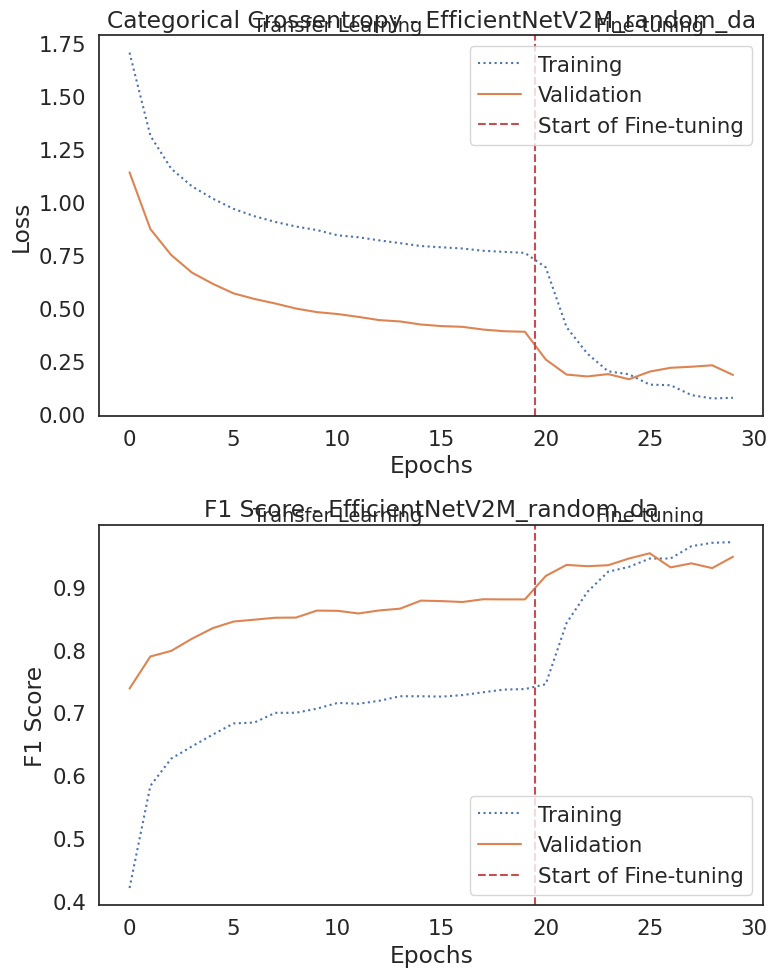

In [ ]:
# Plot loss fucntion and evaluation metric histories
plot_history(history_tl_efficientnetv2m_random_da, history_ft_efficientnetv2m_random_da, "EfficientNetV2M_random_da")

18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step
Accuracy score over the test set: 0.9554
Precision score over the test set: 0.958
Recall score over the test set: 0.9554
F1 score over the test set: 0.9558


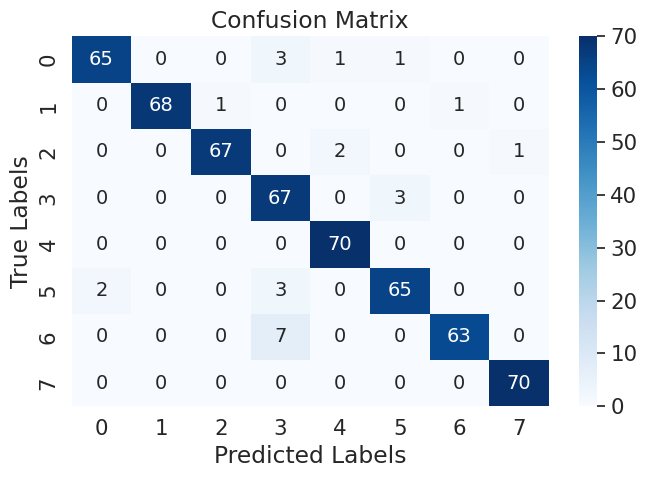

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('EfficientNetV2M_random_augmentation.keras')
#Make predictions for model1 on the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')
test_precision = precision_score(y_test, y_pred, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')
test_recall = recall_score(y_test, y_pred, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute confusion matrices for both models
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Optionally, you can delete the models to free up resources
del model

# Grad-CAM

In [ ]:
!pip install --upgrade Pillow

In [ ]:
import cv2
from PIL import Image, ImageDraw, ImageFont

def create_superpos(img, model):
    final_output, label_index, predictions = compute_CAM(model, img)

    # Normalize heatmap
    heatmap = np.maximum(final_output, 0)
    heatmap /= heatmap.max()

    # Resize heatmap
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Apply colormap
    heatmap_colored = cv2.applyColorMap((heatmap_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Blend images
    alpha = 0.5
    print(img.shape)
    print(heatmap_colored.shape)
    overlayed_image = cv2.addWeighted(img, 1 - alpha, heatmap_colored, alpha, 0)
    return overlayed_image

def select_one_image_per_class(images, labels, class_names=None):
    """
    Selects one image per unique class from the given images and labels.

    Args:
        images (np.ndarray): Array of images with shape (N, H, W, C) or (N, H, W).
        labels (np.ndarray): Array of class labels with shape (N,).
        class_names (list of str, optional): List of class names corresponding to labels.

    Returns:
        selected_images (list of np.ndarray): List of one image per class.
        selected_labels (list): List of class labels corresponding to the selected images.
        selected_class_names (list of str): List of class names if `class_names` is provided.
    """
    # Ensure the input arrays have valid dimensions
    if len(images) != len(labels):
        raise ValueError("The number of images must match the number of labels.")

    # Find the unique classes
    unique_classes = np.unique(labels)
    np.sort(unique_classes)
    print(unique_classes)
    for i in unique_classes:
      print(i)

    # Select one image for each class
    selected_images = []
    selected_labels = []
    for cls in unique_classes:
        class_indices = np.where(labels == cls)[0]
        if len(class_indices) == 0:
            continue  # Skip if no images for the class
        selected_index = class_indices[0]  # Take the first image for the class
        selected_images.append(images[selected_index])
        selected_labels.append(cls)

    # Map class names if provided
    selected_class_names = None
    if class_names is not None:
        selected_class_names = [class_names[cls] for cls in selected_labels]

    return selected_images, selected_labels, selected_class_names

def create_collage_with_text_per_image(images, texts, output_path="output_image.png", grid_size=(2, 4), image_size=(96, 96), font_size=24):
    """
    Creates a collage of images with custom text on each image and saves the result.

    Args:
        images (list of np.ndarray): List of images as NumPy arrays (H, W, C).
        texts (list of str): List of text labels for each image.
        output_path (str): Path to save the final image.
        grid_size (tuple): Number of rows and columns in the grid (default: 2x4).
        image_size (tuple): Size (H, W) to resize each image in the grid.
        font_size (int): Font size for the text overlay.

    Returns:
        None: Displays and saves the collage.
    """
    # Check input validity
    if len(images) != len(texts):
        raise ValueError("The number of images must match the number of texts.")

    if len(images) != grid_size[0] * grid_size[1]:
        raise ValueError("The number of images must match the grid size (rows * columns).")

    # Resize all images to the same size
    resized_images = [cv2.resize(img, image_size) for img in images]

    # Create a blank canvas for the collage
    grid_h = grid_size[0] * image_size[0]
    grid_w = grid_size[1] * image_size[1]
    collage = np.zeros((grid_h, grid_w, 3), dtype=np.uint8)

    # Convert all images to PIL for text overlay
    images_with_text = []
    for img, text in zip(resized_images, texts):
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)

        # Choose font (default to a simple one if specific fonts aren't available)
        try:
            font = ImageFont.truetype("arial.ttf", font_size)
        except IOError:
            font = ImageFont.load_default()

        # Add text overlay to the image
        # Use getsize instead of textsize if using an older version of Pillow
        text_size = draw.textbbox((0, 0), text, font=font) # changed to textbbox
        text_width = text_size[2] - text_size[0]  # Calculate width
        text_height = text_size[3] - text_size[1] # Calculate height
        text_position = ((image_size[1] - text_width) // 2, image_size[0] - text_height - 10)

        draw.text(text_position, text, fill=(255, 255, 255), font=font)

        # Convert back to NumPy for collage assembly
        images_with_text.append(np.array(pil_img))

    # Populate the canvas with images
    for i, img in enumerate(images_with_text):
        row = i // grid_size[1]
        col = i % grid_size[1]
        y1, y2 = row * image_size[0], (row + 1) * image_size[0]
        x1, x2 = col * image_size[1], (col + 1) * image_size[1]
        collage[y1:y2, x1:x2] = img

    # Save the collage
    cv2.imwrite(output_path, cv2.cvtColor(collage, cv2.COLOR_RGB2BGR))

def apply_grad(images, model):
    grad_array = []
    for image in images:
      grad_array.append(create_superpos(image,model))
    return grad_array

In [ ]:
def compute_CAM(model, img):
    # Ensure input dimensions match the model requirements
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.efficientnet_v2.preprocess_input(img)

    # Predict and get the top class index
    predictions = model.predict(img, verbose=0)
    label_index = np.argmax(predictions)

    # Extract the dense layer weights
    class_weights = model.layers[-1].get_weights()[0]  # Last layer weights
    class_weights_winner = class_weights[:, label_index]

    # Get the final convolutional layer
    final_conv_layer = tf.keras.Model(
        inputs=  model.get_layer('efficientnetv2-m').input,
        outputs = model.get_layer('efficientnetv2-m').get_layer('top_activation').output)
    # Compute the convolutional outputs
    conv_outputs = final_conv_layer(img)
    conv_outputs = np.squeeze(conv_outputs)  # Remove batch dimension

    # Upsample the convolutional outputs to match input size
    conv_outputs_upsampled = tf.image.resize(conv_outputs, (img.shape[1], img.shape[2])).numpy()

    # Flatten the spatial dimensions
    height, width, channels = conv_outputs_upsampled.shape
    mat_for_mult = conv_outputs_upsampled.reshape((height * width, channels))

    # Compute the CAM
    final_output = np.dot(mat_for_mult, class_weights_winner)
    final_output = final_output.reshape((height, width))  # Reshape to match upsampled size

    return final_output, label_index, predictions

In [ ]:
# Load best model
model = tfk.models.load_model('base_no_dense_2aug_weights.keras')
# sub_model = model.get_layer('efficientnetv2-m')

# Gloabal variables needed
IMG_SIZE = 96

In [ ]:
classes_names = ["Basophil", "Eosinophil", "Erythroblast", "granulocytes (I)", "Lymphocyte", "Monocyte", "Neutrophil", "Platelet"]
images, labels, selected_class_names = select_one_image_per_class(X_test, y_test, classes_names)
print(len(images))
images = apply_grad(images, model)
print(len(images))
create_collage_with_text_per_image(images, classes_names, output_path="correct_grad.png", grid_size=(2, 4), image_size=(96, 96), font_size=24)

[0 1 2 3 4 5 6 7]
0
1
2
3
4
5
6
7
8
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
8
